In [2]:
# stage 1 prbolem definition
# classfy who can survive

In [3]:
# stage 2 acquire data

import os

data_dir = 'data'
competition_name = 'spaceship-titanic'

# download data
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    if os.system(f'cd {data_dir} && kaggle competitions download -c {competition_name} && tar -xzvf {competition_name}.zip') != 0:
        print('download data error')

import numpy as np
import pandas as pd

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

['HomePlanet' 'CryoSleep' 'Destination' 'Age' 'VIP' 'RoomService'
 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Name' 'Transported' 'Deck'
 'Side' 'PassengerNumber']
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HomePlanet       8492 non-null   object 
 1   CryoSleep        8476 non-null   object 
 2   Destination      8511 non-null   object 
 3   Age              8514 non-null   float64
 4   VIP              8490 non-null   object 
 5   RoomService      8512 non-null   float64
 6   FoodCourt        8510 non-null   float64
 7   ShoppingMall     8485 non-null   float64
 8   Spa              8510 non-null   float64
 9   VRDeck           8505 non-null   float64
 10  Name             8493 non-null   object 
 11  Transported      8693

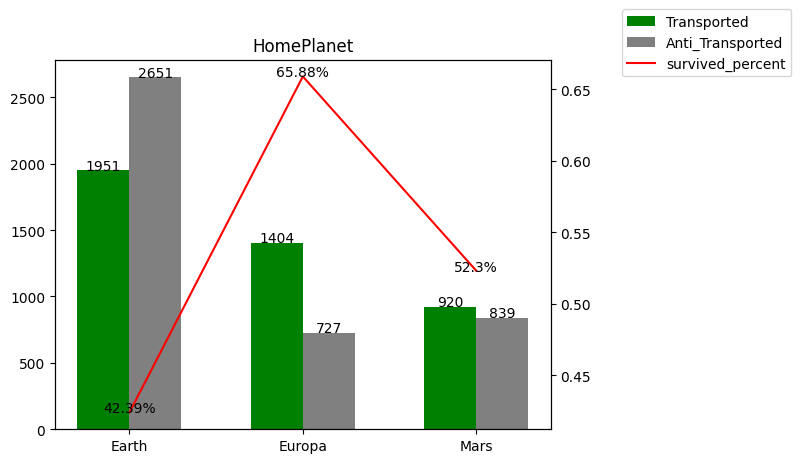

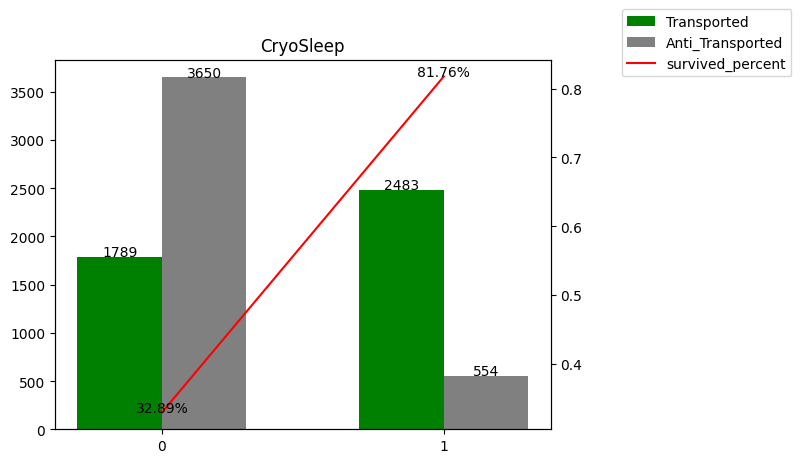

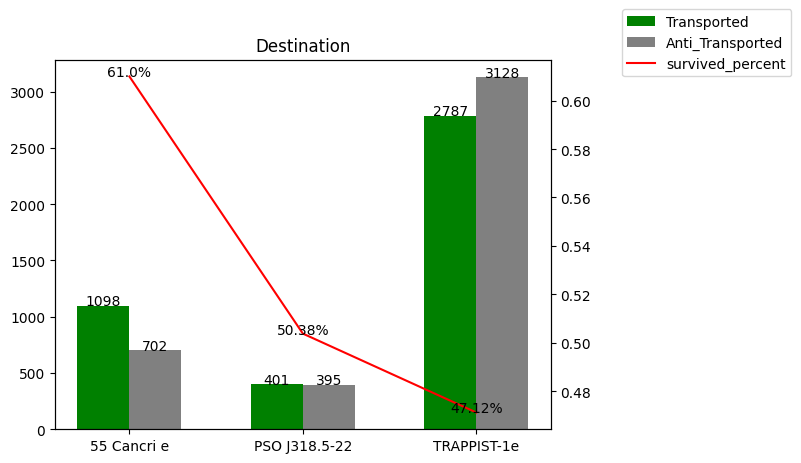

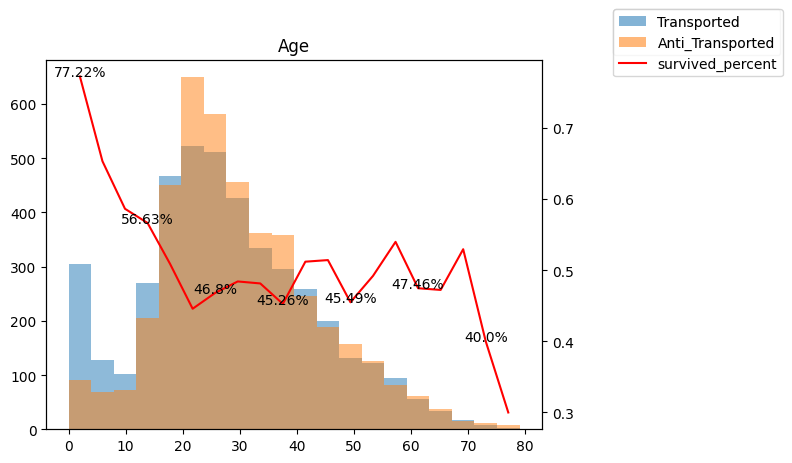

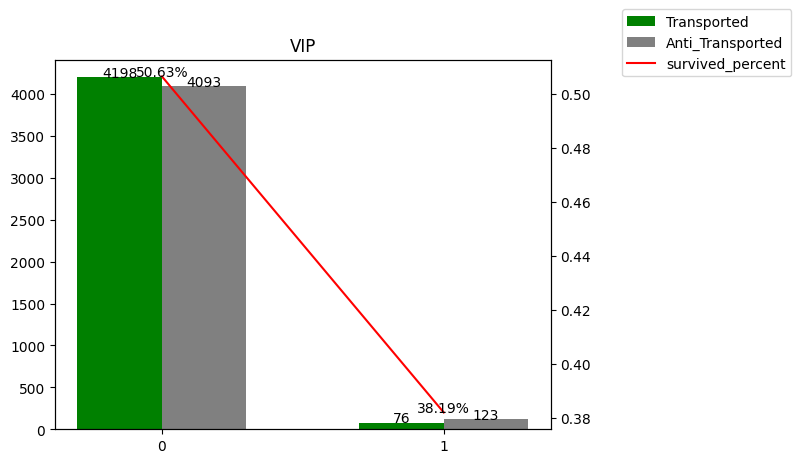

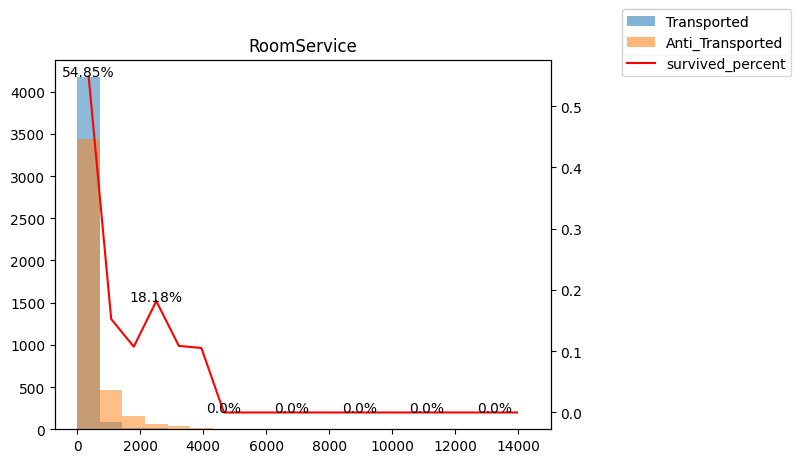

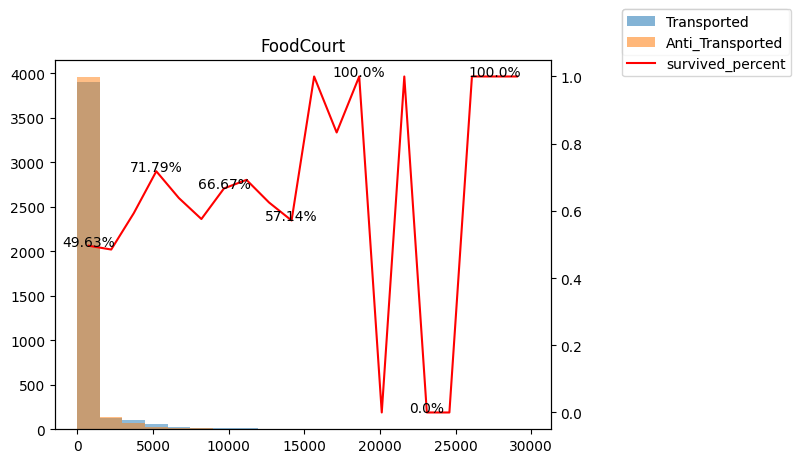

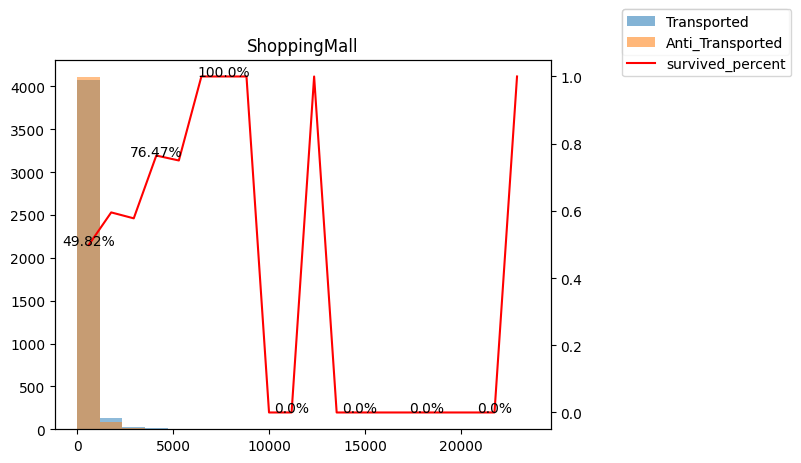

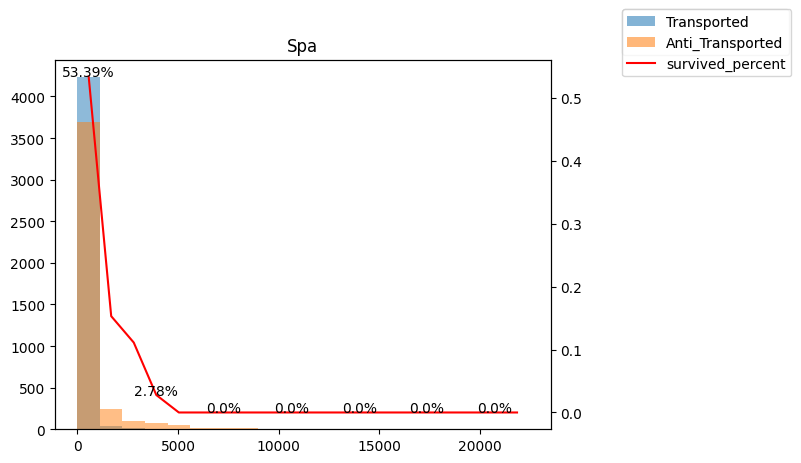

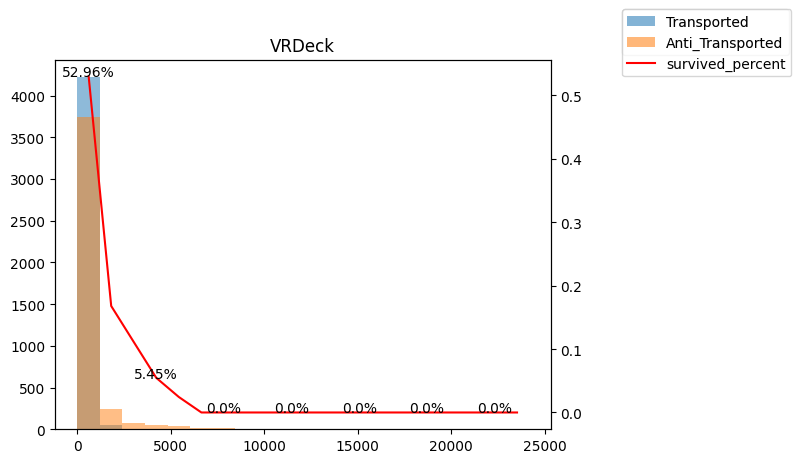

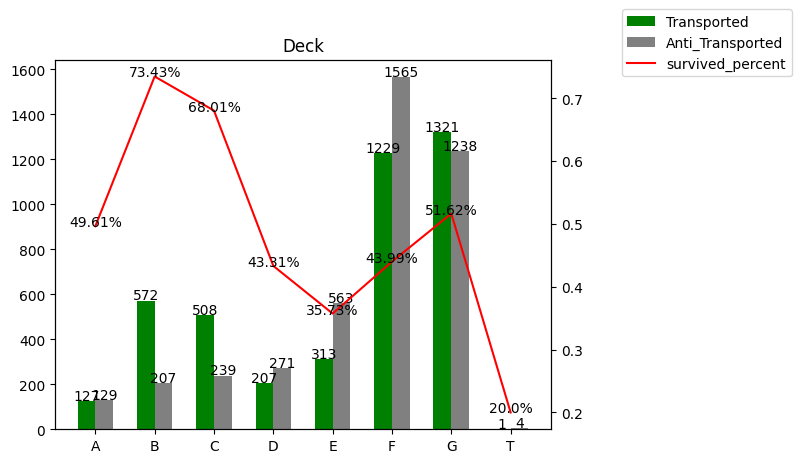

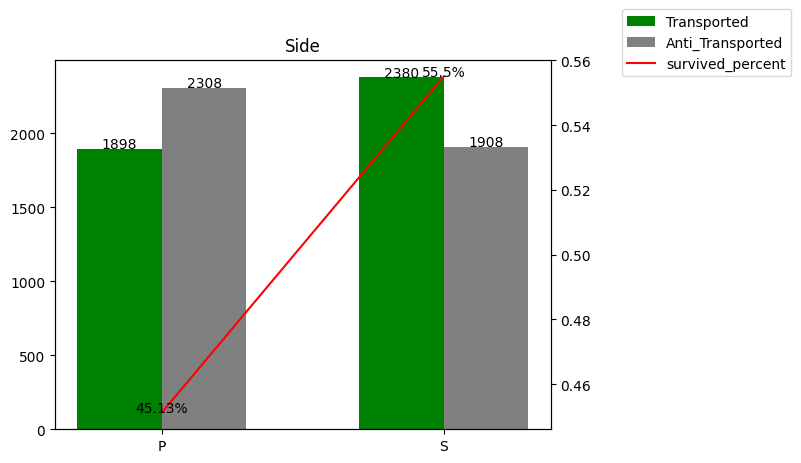

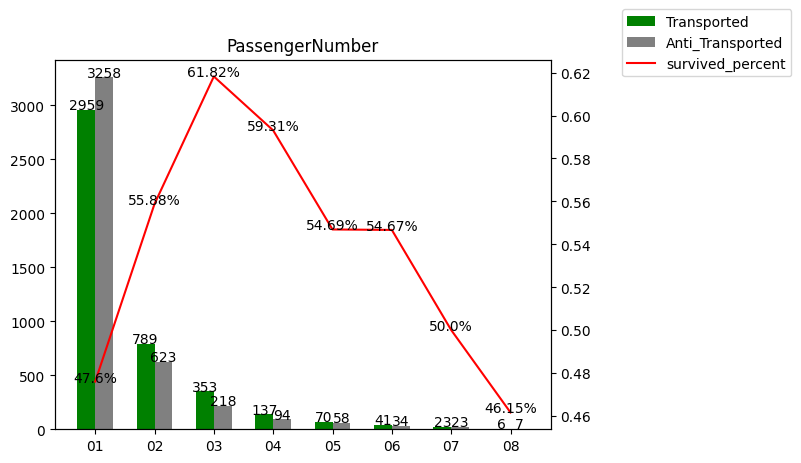

['Name', 'Transported']
----------------------------------------------------------------------------------------------------


In [4]:
# stage 3 read data and analyze data

import matplotlib.pyplot as plt

TARGET = 'Transported'

def _print(info):
    print(info)
    print_line()

def print_line():
    print('-' * 100)

def print_df_basic(df: pd.DataFrame):
    _print(df.columns.values)
    _print(df.info())
    _print(df.describe()) # 连续型数据量统计
    desc = df.describe(include=['O']) # 离散型数据量统计
    _print(desc)
    unique_percent = desc.loc['unique'] / desc.loc['count']
    unique_percent = unique_percent.apply(lambda x: format(1 - x, '.2%'))
    _print(unique_percent)


def print_df_statistic(df):
    # 分布统计表
    for column in df.columns:
        target = TARGET
        if column != target:
            statistic = df[[column, target]].groupby([column], as_index=False).mean().sort_values(by=target, ascending=False)
            _print(statistic)

def draw_bar(column, df, target):
    anti_target = f'Anti_{target}'
    percent = 'Percent'
    total_count = df[[column, target]].groupby([column]).count()
    survived = df[[column, target]].groupby([column]).sum()
    survived[anti_target] = pd.Series(total_count[target]) - pd.Series(survived[target])
    survived[percent] = pd.Series(survived[target]) / pd.Series(total_count[target])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    x_index = survived.index
    if x_index.dtype == 'object':
        x_index = np.arange(len(survived.index))
        ax.set_xticks(x_index)
        ax.set_xticklabels(survived.index)
    else:
        ax.set_xticks(x_index)
    width = 0.3
    ax.bar(x_index-width/2, survived[target], label=target, width=width, color='green')
    ax.bar(x_index+width/2, survived[anti_target], label=anti_target, width=width, color='grey')

    for x, y1, y2 in zip(x_index, survived[target], survived[anti_target]):
        plt.text(x-width/2, y1+5, str(y1), ha='center')
        plt.text(x+width/2, y2+5, str(y2), ha='center')

    ax_percent = ax.twinx()
    ax_percent.plot(x_index, survived[percent], label = 'survived_percent', color='red')
    for x, y in zip(x_index, survived[percent]):
        plt.text(x, y, str(round(y * 100, 2))+'%', ha='center')

    fig.legend(loc=2, bbox_to_anchor=(1,1))
    plt.title(column)
    plt.show()


def draw_hist(column: str, df: pd.DataFrame, target: str):
    anti_target = f'Anti_{target}'
    percent = 'Percent'
    df = df[[column, target]]
    target_column = df[df[target] == 1]
    anti_target_column = df[df[target] == 0]
    x_min, x_max = min(target_column[column].min(), anti_target_column[column].min()), max(target_column[column].max(), anti_target_column[column].max())
    fig = plt.figure()
    ax = fig.add_subplot(111)
    target_n, bins, patches = ax.hist(target_column[column], 20, alpha=0.5, label=target, range=(x_min, x_max))
    anti_target_n, anti_bins, anti_patches = ax.hist(anti_target_column[column], 20, alpha=0.5, label=anti_target, range=(x_min, x_max))
    fig.legend(loc=2, bbox_to_anchor=(1,1))

    ax_percent = ax.twinx()
    total = (np.array(anti_target_n) + np.array(target_n))
    total[np.where(total == 0)] = 1
    percent = np.array(target_n) / total
    bins = np.array(bins)
    x_index = (bins[:-1] + bins[1:]) / 2
    ax_percent.plot(x_index, percent, label = 'survived_percent', color='red')
    for x, y in zip(x_index[::3], percent[::3]):
        plt.text(x, y, str(round(y * 100, 2))+'%', ha='center')

    fig.legend(loc=2, bbox_to_anchor=(1,1))
    plt.title(column)


def print_df_pic(df):
    # 分布统计图
    skips = []
    for column in df.columns:
        target = TARGET
        bar_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'PassengerNumber']
        hist_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        try:
            if column in bar_columns:
                draw_bar(column, df, target)
            elif column in hist_columns:
                draw_hist(column, df, target)
            else:
                skips.append(column)
        except Exception as e:
            print(e)
            continue
    _print(skips)

# drop useless features
def drop_feature(df: pd.DataFrame, features) -> pd.DataFrame:
    for feature in features:
        if feature in df.columns.values:
            df = df.drop(feature, axis=1)
    return df

def handle_cabin(df: pd.DataFrame) -> pd.DataFrame:
    if 'Cabin' in df.columns.values:
        parts = df.Cabin.str.split('/', expand=True)
        df['Deck'] = parts[0]
        df['Side'] = parts[2]

    df = drop_feature(df, ['Cabin'])
    return df

def handle_passenger_id(df: pd.DataFrame) -> pd.DataFrame:
    if 'PassengerId' in df.columns.values:
        parts = df.PassengerId.str.split('_', expand=True)
        df['PassengerNumber'] = parts[1]
        df.set_index(['PassengerId'], inplace=True)
    return df

train_df = handle_cabin(train_df)
train_df = handle_passenger_id(train_df)

print_df_basic(train_df)
print_df_statistic(train_df)
print_df_pic(train_df)

# combine = [train_df, test_df]
# for df in combine:
#     df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# pd.crosstab(train_df['Title'], train_df['Sex']) # 并列条件的count

In [5]:
# stage 4 Wrangle, prepare, cleanse the data.

from sklearn.preprocessing import StandardScaler

def category_mapping(df: pd.DataFrame, features = []):
    if len(features) == 0:
        features = df.columns.values
    for feature in features:
        if feature not in df.columns.values:
            continue
        _dtype = df[feature].unique().dtype
        if _dtype == object:
            dummy = pd.get_dummies(df[feature])
            df = pd.concat([df, dummy], axis=1)
            df = drop_feature(df, [feature])
        if _dtype == bool:
            mapping = {_key: idx + 1 for idx, _key in enumerate(df[feature].unique())}
            df[feature] = df[feature].map(mapping)
    return df

def fill_frequent(df: pd.DataFrame, features = []) -> pd.DataFrame:
    if len(features) == 0:
        features = df.columns.values
    for feature in features:
        if not df[feature].isnull().any():
            continue
        freq = df[feature].dropna().mode()[0]
        df[feature] = df[feature].fillna(freq)
        # df = category_mapping(df, [feature])
    return df

def handle_large_num(df: pd.DataFrame, features) -> pd.DataFrame:
    for feature in features:
        scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
        df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
    return df

def handle_df(df):
    df = handle_cabin(df)
    df = handle_passenger_id(df)
    df = fill_frequent(df)
    df = category_mapping(df, ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'PassengerNumber'])
    df = drop_feature(df, ['Name'])
    return df

train_df_handled = handle_df(train_df)
print(train_df_handled.info())
# print_df_basic(test_df)
test_df_handled = handle_df(test_df)
print(test_df_handled.info())


<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CryoSleep      8693 non-null   int64  
 1   Age            8693 non-null   float64
 2   VIP            8693 non-null   int64  
 3   RoomService    8693 non-null   float64
 4   FoodCourt      8693 non-null   float64
 5   ShoppingMall   8693 non-null   float64
 6   Spa            8693 non-null   float64
 7   VRDeck         8693 non-null   float64
 8   Transported    8693 non-null   bool   
 9   Earth          8693 non-null   uint8  
 10  Europa         8693 non-null   uint8  
 11  Mars           8693 non-null   uint8  
 12  55 Cancri e    8693 non-null   uint8  
 13  PSO J318.5-22  8693 non-null   uint8  
 14  TRAPPIST-1e    8693 non-null   uint8  
 15  A              8693 non-null   uint8  
 16  B              8693 non-null   uint8  
 17  C              8693 non-null   uint8  
 18  D   

In [6]:
# stage 5 model, predict

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self, n_input):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 2)
        # self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        # x = self.dropout(x)
        x = F.sigmoid(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x

def nn_predict(X_train: pd.DataFrame, Y_train, X_test):
    model = Net(len(X_train.columns.values))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    X_train, Y_train = (Variable(torch.FloatTensor(X_train.values)), Variable(torch.LongTensor(Y_train.values)))

    for epoch in range(2000):
        prediction = model(X_train)
        loss = criterion(prediction, Y_train)
        if epoch % 100 == 0:
            print("loss: ", loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    prediction = model(Variable(torch.FloatTensor(X_test.values)))
    values, labels = torch.max(prediction, 1)
    survived = labels.data.numpy()
    return handle_result(X_test, survived)

def handle_result(df, pred):
    result = df.drop(df.columns.values, axis=1)
    result[TARGET] = pred
    return result


def predict(X_train: pd.DataFrame, Y_train, X_test, classfier):
    classfier.fit(X_train, Y_train)
    Y_pred = classfier.predict(X_test)
    acc_score = round(classfier.score(X_train, Y_train) * 100, 2)
    print(acc_score)
    return handle_result(X_test, Y_pred)


XX_train = train_df_handled.drop(TARGET, axis=1)
YY_train = train_df_handled[TARGET]
XX_test  = test_df_handled.copy()


/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# submit

def run_predict(X_train: pd.DataFrame, Y_train, X_test):
    classfiers = {
        'lr': LogisticRegression(),
        'svc': SVC(), 
        'knn': KNeighborsClassifier(n_neighbors = 3),
        'gnb': GaussianNB(),
        'perceptron': Perceptron(),
        'linearSVC': LinearSVC(),
        'sgd': SGDClassifier(),
        'decision_tree': DecisionTreeClassifier(),
        'forest': RandomForestClassifier(n_estimators=100),
    }
    results = {}
    for name, classfier in classfiers.items():
        print(name)
        results[name] = predict(X_train, Y_train, X_test, classfier)
    return results


# results = run_predict(XX_train, YY_train, XX_test)
results = {'category_nn': nn_predict(XX_train, YY_train, XX_test)}
result_file = 'submission.csv'
for name, result in results.items():
    result.to_csv(os.path.join(data_dir, result_file))
    os.system(f'cd {data_dir} && kaggle competitions submit -c {competition_name} -f {result_file} -m "{name}"')
os.system(f'kaggle competitions submissions {competition_name}')

/opt/homebrew/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss:  tensor(0.6966, grad_fn=<NllLossBackward0>)
loss:  tensor(0.5994, grad_fn=<NllLossBackward0>)
loss:  tensor(0.5444, grad_fn=<NllLossBackward0>)
loss:  tensor(0.5169, grad_fn=<NllLossBackward0>)
loss:  tensor(0.5050, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4996, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4968, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4950, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4937, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4926, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4916, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4908, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4901, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4894, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4888, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4882, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4877, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4872, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4867, grad_fn=<NllLossBackward0>)
loss:  tensor(0.4863, grad_fn=<NllLossBackward0>)


100%|██████████| 41.8k/41.8k [00:02<00:00, 15.4kB/s]


400 - Bad Request
fileName        date                 description  status    publicScore  privateScore  
--------------  -------------------  -----------  --------  -----------  ------------  
submission.csv  2023-01-28 13:14:36  sgd          complete  0.68061                    
submission.csv  2023-01-28 13:14:31  linearSVC    complete  0.75029                    
submission.csv  2023-01-28 13:14:26  perceptron   complete  0.68833                    
submission.csv  2023-01-28 13:14:21  gnb          complete  0.67921                    
submission.csv  2023-01-28 13:14:16  knn          complete  0.00000                    
submission.csv  2023-01-28 13:14:10  svc          complete  0.79027                    
submission.csv  2023-01-28 13:14:04  lr           complete  0.70960                    
submission.csv  2023-01-28 13:13:06  gnb          complete  0.67921                    
submission.csv  2023-01-28 13:13:00  knn          complete  0.00000                    
submission.csv

0